# Linear Model + non linear activation function

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
data_folder = './../Data/cifar/cifar-10/'
Xtr = np.load(data_folder + 'Xtr.npy')
ytr = np.load(data_folder + 'ytr.npy')
Xte = np.load(data_folder + 'Xte.npy')
yte = np.load(data_folder + 'yte.npy')
labels = read_dictionary = np.load(data_folder + 'labels_dict.npy',allow_pickle='TRUE').item()
true_shape = (32, 32, 3)
# transpose to (1,2,0)
n = int(Xtr.shape[0]*0.8)
Xtr , Xval = Xtr[:n] , Xtr[n:]
ytr , yval = ytr[:n] , ytr[n:]
Xtr.shape , ytr.shape , Xval.shape , yval.shape , Xte.shape , yte.shape , len(labels) , labels

((40000, 3072),
 (40000,),
 (10000, 3072),
 (10000,),
 (10000, 3072),
 (10000,),
 10,
 {0: 'jetliner',
  1: 'shooting',
  2: 'gamecock',
  3: 'domestic',
  4: 'wapiti',
  5: 'toy',
  6: 'green',
  7: 'lippizan',
  8: 'hydrofoil',
  9: 'dustcart'})

In [8]:
Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))
ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

## 2 layer MLP
2 layer neural network with linear model and non linear activation function.

flow :

3072 -> 100 -> 10 

#### Activations : relu

In [4]:
def relu(x):
    return x * (x > 0) 

def d_relu(x):
    return 1. * (x > 0) 

In [27]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis = 1).reshape(-1,1) 

def d_softmax(x):
    return softmax(x) * (1 - softmax(x))

### Data preprocessing

In [8]:
## Subtract mean image
Xtr -= torch.mean(Xtr, dim = 1, keepdim = True)
Xtr.shape

torch.Size([40000, 3072])

### Batch Sampler

In [15]:
class dataset():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.i = 0
        self.mask = torch.arange(self.n)
    
    def next_batch(self, batch_size):
        if self.i + batch_size > self.n:
            self.reset()
        X_batch = self.X[self.mask][self.i : self.i + batch_size]
        y_batch = self.y[self.mask][self.i : self.i + batch_size]
        self.i += batch_size
        return X_batch, y_batch 

    def reset(self):
        self.i = 0
        self.mask = torch.randperm(self.n)

In [32]:
train = dataset(Xtr, ytr_enc)
val = dataset(Xval, yval_enc)

### Weight init (Xaiver init & Kaiming init)

In [104]:
h1_neurons = 100


W1 = torch.rand(Xtr.shape[1], h1_neurons) * np.sqrt(2.0 / Xtr.shape[1]) * 0.01 # Kaiming He initialization
b1 = torch.zeros(h1_neurons)

W2 = torch.rand(h1_neurons, len(labels)) * np.sqrt(2.0 / h1_neurons) * 0.01 # Kaiming He initialization 
b2 = torch.zeros(len(labels))

In [105]:
parameters = [W1, b1, W2, b2] 
updates = [torch.zeros_like(p) for p in parameters] 

def grad_zero(updates):
    for u in updates:
        u.zero_()
        
grad_zero(updates)
updates[0][:5,:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [106]:
def forward(X, W1, b1, W2, b2):
    h1 = X @ W1 + b1
    a1 = relu(h1)
    h2 = a1 @ W2 + b2
    a2 = softmax(h2)
    return h1, a1, h2, a2

Xbtr, ybtr = train.next_batch(10)
h1, a1, h2, a2 = forward( Xbtr,*parameters)
a1[:5,:5] , a2[:5,:5]

(tensor([[2.3066e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.0936e-01],
         [-0.0000e+00, 1.4177e-01, 4.6027e-02, 2.8563e-04, 9.1992e-02],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, 1.1815e-01, -0.0000e+00],
         [1.4938e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.5517e-01],
         [2.5581e-02, -0.0000e+00, 7.9031e-02, 4.3658e-01, -0.0000e+00]]),
 tensor([[0.1000, 0.1000, 0.0999, 0.1001, 0.0999],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1001, 0.1000, 0.1000, 0.1001, 0.0999],
         [0.1001, 0.1000, 0.0999, 0.1001, 0.1000]]))

In [107]:
def BatchNorm(h, gamma = 1, beta = 0, eps = 1e-5):
    # print(h.shape)
    mu_bn = torch.mean(h,axis = 0)
    var_bn = torch.var(h,axis = 0)
    # print(mu_bn.shape , var_bn.shape)
    h_hat = h - mu_bn / torch.sqrt(var_bn + eps)
    # print(h_hat.shape)
    y_k = gamma * h_hat + beta
    return y_k


def forward(X, W1, b1, W2, b2, gamma = 1, beta = 0):
    h1 = X @ W1 + b1
    bn1 = BatchNorm(h1, gamma, beta)
    a1 = relu(bn1)
    h2 = a1 @ W2 + b2
    bn2 = BatchNorm(h2, gamma, beta)
    a2 = softmax(bn2)
    return h1, a1,  h2, a2

Xbtr, ybtr = train.next_batch(10)
h1, a1,  h2, a2 = forward( Xbtr,*parameters)
a1[:5,:5] , a2[:5,:5]

(tensor([[0.1237, -0.0000, -0.0000, -0.0000, -0.0000],
         [0.0086, -0.0000, -0.0000, -0.0000, -0.0000],
         [0.2934, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [0.1773, 0.0556, -0.0000, -0.0000, -0.0000]]),
 tensor([[0.0973, 0.0995, 0.0768, 0.0917, 0.1427],
         [0.0973, 0.0995, 0.0768, 0.0917, 0.1429],
         [0.0973, 0.0995, 0.0769, 0.0916, 0.1429],
         [0.0974, 0.0995, 0.0767, 0.0916, 0.1429],
         [0.0973, 0.0996, 0.0768, 0.0917, 0.1430]]))

In [108]:
def loss(y, y_hat):
    return -torch.sum(y * torch.log(y_hat))

def accuracy(y, y_hat):
    return torch.sum(y.argmax(dim = 1) == y_hat.argmax(dim = 1)) / y.shape[0]

lss = loss(ybtr, a2)
acc = accuracy(ybtr, a2)
lss , acc

(tensor(23.0551), tensor(0.1000))

In [109]:
def backward(X, y, h1, a1, h2, a2, W1, b1, W2, b2):
    m = X.shape[0]
    dy = a2 - y
    dW2 = a1.T @ dy
    db2 = torch.sum(dy, axis = 0)
    da1 = dy @ W2.T
    dh1 = da1 * d_relu(a1)
    dW1 = X.T @ dh1
    db1 = torch.sum(dh1, axis = 0)
    return dW1, db1, dW2, db2

dW1, db1, dW2, db2 = backward(Xbtr, ybtr, h1, a1, h2, a2, *parameters) 
dW1.shape, db1.shape, dW2.shape, db2.shape

(torch.Size([3072, 100]),
 torch.Size([100]),
 torch.Size([100, 10]),
 torch.Size([10]))

Iteration       0 Loss 2218.9838867
Iteration      10 Loss 2223.4924316
Iteration      20 Loss 2223.1689453
Iteration      30 Loss 2200.8801270
Iteration      40 Loss 2176.1425781
Iteration      50 Loss 2176.8764648
Iteration      60 Loss 2187.6982422
Iteration      70 Loss 2170.9963379
Iteration      80 Loss 2153.6015625
Iteration      90 Loss 2160.8793945


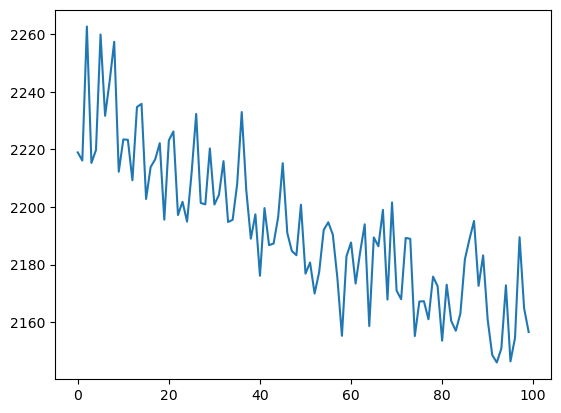

In [112]:
class adam:
    
    def __init__(self, parameters, lr = 0.001, b1 = 0.9, b2 = 0.999, eps = 1e-8):
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.parameters = parameters
        self.m_k = [0 for _ in parameters]
        self.u_k = [0 for _ in parameters]
    
    def update(self, grads):
        for i in range(len(self.parameters)):
            self.m_k[i] = self.b1 * self.m_k[i] + (1 - self.b1) * grads[i]
            self.u_k[i] = self.b2 * self.u_k[i] + (1 - self.b2) * grads[i]**2
            m_k_hat = self.m_k[i] / (1 - self.b1)
            u_k_hat = self.u_k[i] / (1 - self.b2)
            self.parameters[i] -= self.lr * m_k_hat / (torch.sqrt(u_k_hat) + self.eps)
    
    def optimize(self, forward, backward, loss, train , max_iters = 10): 
        train_losses = []
        
        for i in range(max_iters):
            X , y = train.next_batch(1000)
            h1, a1, h2, a2 = forward(X, *self.parameters)
            grads = backward(X, y, h1, a1, h2, a2, *self.parameters)
            lss = loss(y, a2)
            self.update(grads)
            train_losses.append(lss)
            if i % (max_iters//10) == 0:
                print(f'Iteration {i:7} Loss {lss:.7f}')
        return train_losses

adam_opt = adam(parameters, lr = 1e-6)
lss_d = adam_opt.optimize(forward, backward, loss, train, max_iters = 100)

plt.plot(lss_d)

Iteration       0 Loss 2307.2929688
Iteration    1000 Loss 2048.8305664
Iteration    2000 Loss 1935.7929688
Iteration    3000 Loss 1906.7773438
Iteration    4000 Loss 1863.6617432
Iteration    5000 Loss 1767.7055664
Iteration    6000 Loss 1780.6060791
Iteration    7000 Loss 1800.4802246
Iteration    8000 Loss 1743.0712891
Iteration    9000 Loss 1692.9034424


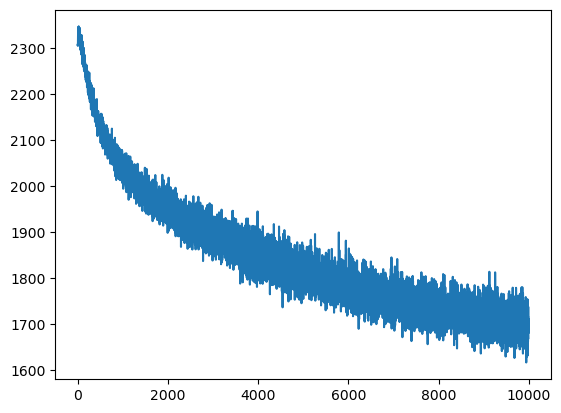

In [113]:
h1_neurons = 100


W1 = torch.rand(Xtr.shape[1], h1_neurons) * np.sqrt(2.0 / Xtr.shape[1]) * 0.01 # Kaiming He initialization
b1 = torch.zeros(h1_neurons)

W2 = torch.rand(h1_neurons, len(labels)) * np.sqrt(2.0 / h1_neurons) * 0.01 # Kaiming He initialization 
b2 = torch.zeros(len(labels))

parameters = [W1, b1, W2, b2] 

adam_opt = adam(parameters, lr = 1e-6)
lss_d = adam_opt.optimize(forward, backward, loss, train, max_iters = 10000)

plt.plot(lss_d)

In [114]:
y_pred = forward(Xte, *adam_opt.parameters)
lsss = loss(yte_enc, y_pred[-1])
lsss
acc = accuracy(yte_enc, y_pred[-1])
acc

tensor(29707.9434)

tensor(0.2223)

### Using Pytorch

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
data_folder = './../Data/cifar/cifar-10/'
Xtr = np.load(data_folder + 'Xtr.npy')
ytr = np.load(data_folder + 'ytr.npy')
Xte = np.load(data_folder + 'Xte.npy')
yte = np.load(data_folder + 'yte.npy')
n = int(Xtr.shape[0] * 0.8)
Xtr, Xval = Xtr[:n], Xtr[n:]
ytr, yval = ytr[:n], ytr[n:]

In [3]:
class CIFARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CIFARDataset(Xtr, ytr)
val_dataset = CIFARDataset(Xval, yval)
test_dataset = CIFARDataset(Xte, yte)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

dummy = next(iter(train_loader))
dummy[0].shape, dummy[1].shape

(torch.Size([64, 3072]), torch.Size([64]))

In [126]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size , bias = True)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FCNet(Xtr.shape[1], 128, len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6)

In [127]:
torch.log(criterion(model(dummy[0]), dummy[1]))

tensor(3.6574, grad_fn=<LogBackward0>)

In [128]:
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 1/10, Train Loss: 14.3870, Val Loss: 10.2577


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 2/10, Train Loss: 9.2214, Val Loss: 8.3999


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 3/10, Train Loss: 7.8601, Val Loss: 7.4702


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 4/10, Train Loss: 7.1003, Val Loss: 6.8679


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 5/10, Train Loss: 6.5787, Val Loss: 6.4438


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 6/10, Train Loss: 6.1704, Val Loss: 6.0816


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 7/10, Train Loss: 5.8438, Val Loss: 5.7758


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 8/10, Train Loss: 5.5655, Val Loss: 5.5155


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 9/10, Train Loss: 5.3328, Val Loss: 5.3214


FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Epoch 10/10, Train Loss: 5.1232, Val Loss: 5.1666


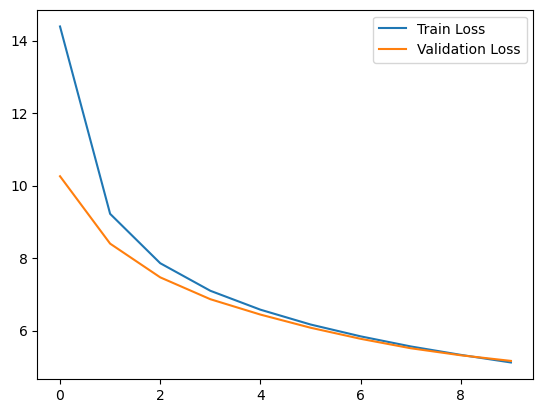

In [129]:
plt.plot(train_losses, label='Train Loss')  
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [130]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 24.99%


In [131]:
epochs = 10
for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/10, Train Loss: 4.9331, Val Loss: 4.9734
Epoch 2/10, Train Loss: 4.7577, Val Loss: 4.7987
Epoch 3/10, Train Loss: 4.6017, Val Loss: 4.6779
Epoch 4/10, Train Loss: 4.4690, Val Loss: 4.5779
Epoch 5/10, Train Loss: 4.3557, Val Loss: 4.4553
Epoch 6/10, Train Loss: 4.2488, Val Loss: 4.3760
Epoch 7/10, Train Loss: 4.1536, Val Loss: 4.2767
Epoch 8/10, Train Loss: 4.0629, Val Loss: 4.1961
Epoch 9/10, Train Loss: 3.9796, Val Loss: 4.1215
Epoch 10/10, Train Loss: 3.9013, Val Loss: 4.0584


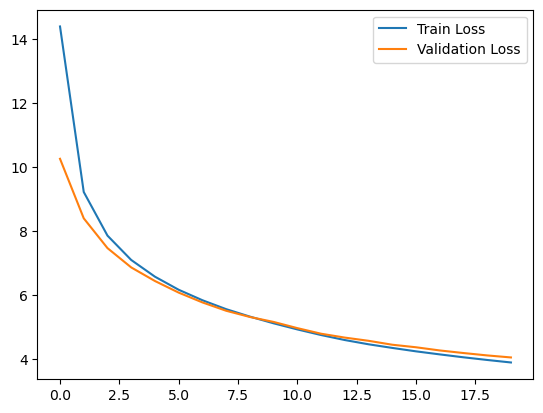

In [132]:
plt.plot(train_losses, label='Train Loss')  
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [133]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 27.10%


# 3 Layer MLP

In [134]:
class FCNet3(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FCNet3, self).__init__()
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2 , bias = True)
        self.fc3 = nn.Linear(hidden_size2, output_size , bias = True)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = FCNet3(Xtr.shape[1], 1024, 64 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

Epoch 1/10, Train Loss: 3.3279, Val Loss: 2.3746
Epoch 2/10, Train Loss: 2.2895, Val Loss: 2.2688
Epoch 3/10, Train Loss: 2.2200, Val Loss: 2.2178
Epoch 4/10, Train Loss: 2.1732, Val Loss: 2.1823
Epoch 5/10, Train Loss: 2.1326, Val Loss: 2.1459
Epoch 6/10, Train Loss: 2.0968, Val Loss: 2.1182
Epoch 7/10, Train Loss: 2.0652, Val Loss: 2.0906
Epoch 8/10, Train Loss: 2.0369, Val Loss: 2.0827
Epoch 9/10, Train Loss: 2.0082, Val Loss: 2.0665
Epoch 10/10, Train Loss: 1.9852, Val Loss: 2.0366


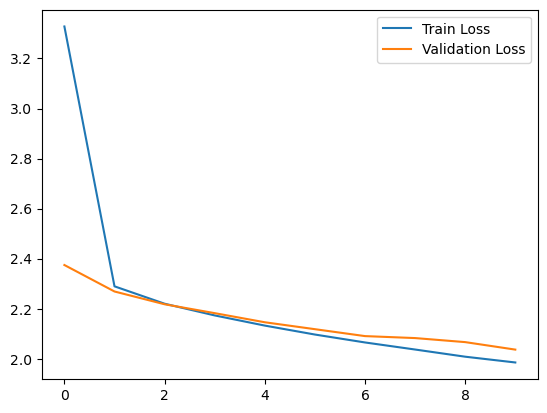

In [135]:
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/10, Train Loss: 1.9600, Val Loss: 2.0262
Epoch 2/10, Train Loss: 1.9378, Val Loss: 2.0087
Epoch 3/10, Train Loss: 1.9173, Val Loss: 1.9948
Epoch 4/10, Train Loss: 1.8961, Val Loss: 1.9817
Epoch 5/10, Train Loss: 1.8763, Val Loss: 1.9730
Epoch 6/10, Train Loss: 1.8579, Val Loss: 1.9523
Epoch 7/10, Train Loss: 1.8394, Val Loss: 1.9435
Epoch 8/10, Train Loss: 1.8201, Val Loss: 1.9388
Epoch 9/10, Train Loss: 1.8032, Val Loss: 1.9167
Epoch 10/10, Train Loss: 1.7868, Val Loss: 1.9079


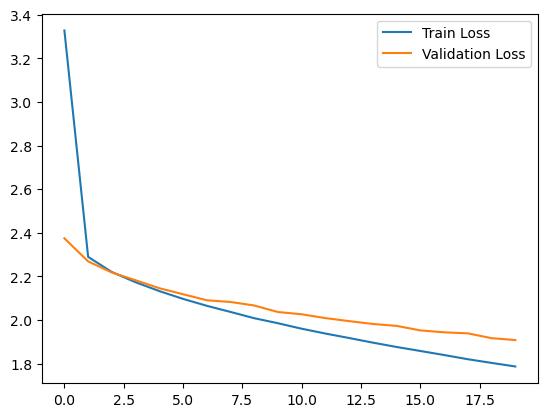

In [136]:
epochs = 10
for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [137]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3(
  (relu): ReLU()
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Test Accuracy: 35.79%


## 3 Layer MLP with Batch Normalization

In [ ]:
class FCNet3_BN(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FCNet3_BN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2 , bias = True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size , bias = True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = FCNet3_BN(Xtr.shape[1], 1024, 128 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

Epoch 1/20, Train Loss: 2.1823, Val Loss: 2.0601
Epoch 2/20, Train Loss: 2.0039, Val Loss: 1.9558
Epoch 3/20, Train Loss: 1.9177, Val Loss: 1.8922
Epoch 4/20, Train Loss: 1.8628, Val Loss: 1.8518
Epoch 5/20, Train Loss: 1.8217, Val Loss: 1.8203
Epoch 6/20, Train Loss: 1.7882, Val Loss: 1.7947
Epoch 7/20, Train Loss: 1.7619, Val Loss: 1.7694
Epoch 8/20, Train Loss: 1.7403, Val Loss: 1.7550
Epoch 9/20, Train Loss: 1.7176, Val Loss: 1.7400
Epoch 10/20, Train Loss: 1.7009, Val Loss: 1.7316
Epoch 11/20, Train Loss: 1.6834, Val Loss: 1.7137
Epoch 12/20, Train Loss: 1.6670, Val Loss: 1.7036
Epoch 13/20, Train Loss: 1.6542, Val Loss: 1.6897
Epoch 14/20, Train Loss: 1.6396, Val Loss: 1.6813
Epoch 15/20, Train Loss: 1.6281, Val Loss: 1.6723
Epoch 16/20, Train Loss: 1.6160, Val Loss: 1.6564
Epoch 17/20, Train Loss: 1.6039, Val Loss: 1.6488
Epoch 18/20, Train Loss: 1.5935, Val Loss: 1.6392
Epoch 19/20, Train Loss: 1.5838, Val Loss: 1.6307
Epoch 20/20, Train Loss: 1.5733, Val Loss: 1.6276


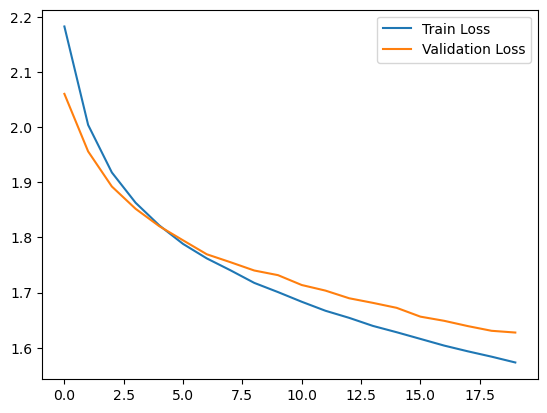

In [147]:
epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [148]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3_BN(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 46.54%


## 3 Layer MLP with Batch Normalization and Dropout

In [141]:
class FCNet3_BN_DO(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FCNet3_BN_DO, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2 , bias = True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size2, output_size , bias = True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = FCNet3_BN_DO(Xtr.shape[1], 1024, 128 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

Epoch 1/10, Train Loss: 2.4666, Val Loss: 2.1869
Epoch 2/10, Train Loss: 2.3503, Val Loss: 2.1086
Epoch 3/10, Train Loss: 2.2933, Val Loss: 2.0596
Epoch 4/10, Train Loss: 2.2412, Val Loss: 2.0273
Epoch 5/10, Train Loss: 2.2039, Val Loss: 1.9980
Epoch 6/10, Train Loss: 2.1767, Val Loss: 1.9749
Epoch 7/10, Train Loss: 2.1500, Val Loss: 1.9563
Epoch 8/10, Train Loss: 2.1334, Val Loss: 1.9401
Epoch 9/10, Train Loss: 2.1144, Val Loss: 1.9229
Epoch 10/10, Train Loss: 2.0931, Val Loss: 1.9139


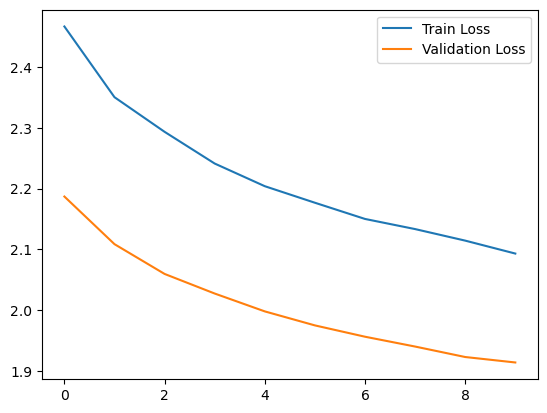

In [142]:
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/10, Train Loss: 2.0825, Val Loss: 1.8968
Epoch 2/10, Train Loss: 2.0639, Val Loss: 1.8902
Epoch 3/10, Train Loss: 2.0586, Val Loss: 1.8802
Epoch 4/10, Train Loss: 2.0447, Val Loss: 1.8735
Epoch 5/10, Train Loss: 2.0288, Val Loss: 1.8644
Epoch 6/10, Train Loss: 2.0211, Val Loss: 1.8564
Epoch 7/10, Train Loss: 2.0147, Val Loss: 1.8508
Epoch 8/10, Train Loss: 2.0071, Val Loss: 1.8441
Epoch 9/10, Train Loss: 1.9912, Val Loss: 1.8352
Epoch 10/10, Train Loss: 1.9859, Val Loss: 1.8280


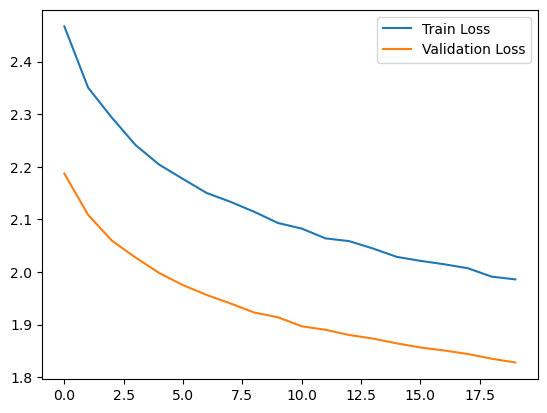

In [144]:
epochs = 10
for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [145]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3_BN_DO(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 39.53%


# Best Model : 3 Layer MLP with Batch Normalization
## training for long

Epoch 1/100, Train Loss: 2.1947, Val Loss: 2.0757
Epoch 2/100, Train Loss: 2.0170, Val Loss: 1.9730
Epoch 3/100, Train Loss: 1.9347, Val Loss: 1.9130
Epoch 4/100, Train Loss: 1.8811, Val Loss: 1.8749
Epoch 5/100, Train Loss: 1.8414, Val Loss: 1.8401
Epoch 6/100, Train Loss: 1.8087, Val Loss: 1.8141
Epoch 7/100, Train Loss: 1.7821, Val Loss: 1.7915
Epoch 8/100, Train Loss: 1.7592, Val Loss: 1.7755
Epoch 9/100, Train Loss: 1.7379, Val Loss: 1.7562
Epoch 10/100, Train Loss: 1.7199, Val Loss: 1.7443
Epoch 11/100, Train Loss: 1.7029, Val Loss: 1.7288
Epoch 12/100, Train Loss: 1.6881, Val Loss: 1.7138
Epoch 13/100, Train Loss: 1.6751, Val Loss: 1.7050
Epoch 14/100, Train Loss: 1.6601, Val Loss: 1.6954
Epoch 15/100, Train Loss: 1.6476, Val Loss: 1.6835
Epoch 16/100, Train Loss: 1.6370, Val Loss: 1.6738
Epoch 17/100, Train Loss: 1.6235, Val Loss: 1.6669
Epoch 18/100, Train Loss: 1.6120, Val Loss: 1.6602
Epoch 19/100, Train Loss: 1.6013, Val Loss: 1.6502
Epoch 20/100, Train Loss: 1.5919, Val Lo

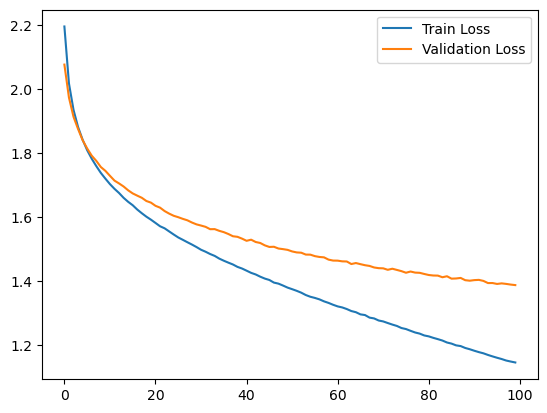

FCNet3_BN(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 52.79%


In [ ]:
model = FCNet3_BN(Xtr.shape[1], 1024, 128 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

epochs = 100
train_losses = []
val_losses = []

saved_models = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    if epoch % (epochs//4) == 0:
        saved_models.append(model.state_dict())
        
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [17]:
def ensemble_predict(models, data_loader):
    preds = []
    loaded_models = []
    for mod in models :
        model = FCNet3_BN(Xtr.shape[1], 1024, 128 , len(labels))
        model.load_state_dict(mod) 
        model.eval()
        loaded_models.append(model)
    actuals = []
    for batch in data_loader:
        inputs, outs = batch
        actuals.append(outs)
        outputs = torch.zeros(inputs.shape[0], len(labels))
        for model in loaded_models:
            outputs += model(inputs)
        preds.append(outputs) 

    accuracy = 0 
    for i in range(len(preds)):
        accuracy += torch.sum(preds[i].argmax(dim = 1) == actuals[i])
    return accuracy / len(data_loader.dataset) , torch.cat(preds), torch.cat(actuals)

ensemble_accuracy, preds, actuals = ensemble_predict(saved_models, test_loader)

preds.shape, actuals.shape
print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")

(torch.Size([10000, 10]), torch.Size([10000]))

Ensemble Accuracy: 52.79%
